#                                           Final Year Project

## Predict whether a mammogram mass is benign or malignant

We'll be using the "mammographic masses" public dataset from the UCI repository (source: https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass)

This data contains 961 instances of masses detected in mammograms, and contains the following attributes:


   1. BI-RADS assessment: 1 to 5 (ordinal)  
   2. Age: patient's age in years (integer)
   3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)
   4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)
   5. Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)
   6. Severity: benign=0 or malignant=1 (binominal)
   
BI-RADS is an assesment of how confident the severity classification is; it is not a "predictive" attribute and so we will discard it. The age, shape, margin, and density attributes are the features that we will build our model with, and "severity" is the classification we will attempt to predict based on those attributes.

Although "shape" and "margin" are nominal data types, which sklearn typically doesn't deal with well, they are close enough to ordinal that we shouldn't just discard them. The "shape" for example is ordered increasingly from round to irregular.

A lot of unnecessary anguish and surgery arises from false positives arising from mammogram results. If we can build a better way to interpret them through supervised machine learning, it could improve a lot of lives.

We are using: 
            
            * Decision tree
            * Random forest
            * KNN
            * Naive Bayes
            * SVM
            * Logistic Regression

# Using Libraries

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,classification_report,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFECV

Import warnings because sometimes classifiers provides FutureWarnings

In [138]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Prepare Your Data

In [139]:
import pandas as pd

masses_data = pd.read_csv('mammographic_masses.data.txt')
masses_data.head()

,5,67,3,5.1,3.1,1
0,4,43,1,1,?,1
1,5,58,4,5,3,1
2,4,28,1,1,3,0
3,5,74,1,5,?,1
4,4,65,1,?,3,0


Make sure you use the optional parmaters in read_csv to convert missing data (indicated by a ?) into NaN, and to add the appropriate column names (BI_RADS, age, shape, margin, density, and severity):

In [140]:
masses_data = pd.read_csv('mammographic_masses.data.txt', na_values=['?'], names = ['BI-RADS', 'age', 'shape', 'margin', 'density', 'severity'])
masses_data.head()

,BI-RADS,age,shape,margin,density,severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,NaN,1


Evaluate whether the data needs cleaning; your model is only as good as the data it's given. Hint: use describe() on the dataframe.

In [141]:
masses_data.describe()

,BI-RADS,age,shape,margin,density,severity
count,959.000000,956.000000,930.000000,913.000000,885.000000,961.000000
mean,4.348279,55.487448,2.721505,2.796276,2.910734,0.463059
std,1.783031,14.480131,1.242792,1.566546,0.380444,0.498893
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,45.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


There are quite a few missing values in the data set. Before we just drop every row that's missing data, let's make sure we don't bias our data in doing so. Does there appear to be any sort of correlation to what sort of data has missing fields? If there were, we'd have to try and go back and fill that data in.

In [142]:
masses_data.loc[(masses_data['age'].isnull()) |
              (masses_data['shape'].isnull()) |
              (masses_data['margin'].isnull()) |
              (masses_data['density'].isnull())]

,BI-RADS,age,shape,margin,density,severity
1,4.0,43.0,1.0,1.0,NaN,1
4,5.0,74.0,1.0,5.0,NaN,1
5,4.0,65.0,1.0,NaN,3.0,0
6,4.0,70.0,NaN,NaN,3.0,0
7,5.0,42.0,1.0,NaN,3.0,0
9,5.0,60.0,NaN,5.0,1.0,1
12,4.0,64.0,1.0,NaN,3.0,0
19,4.0,40.0,1.0,NaN,NaN,0
20,NaN,66.0,NaN,NaN,1.0,1
22,4.0,43.0,1.0,NaN,NaN,0


Benign 516
Malignant 445


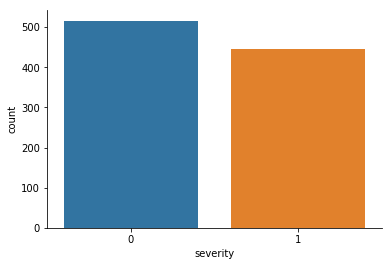

In [143]:
ax=sns.countplot(masses_data['severity'], label = 'Count')
B, M = masses_data['severity'].value_counts()
print ('Benign', B)
print ('Malignant', M)

sns.despine()

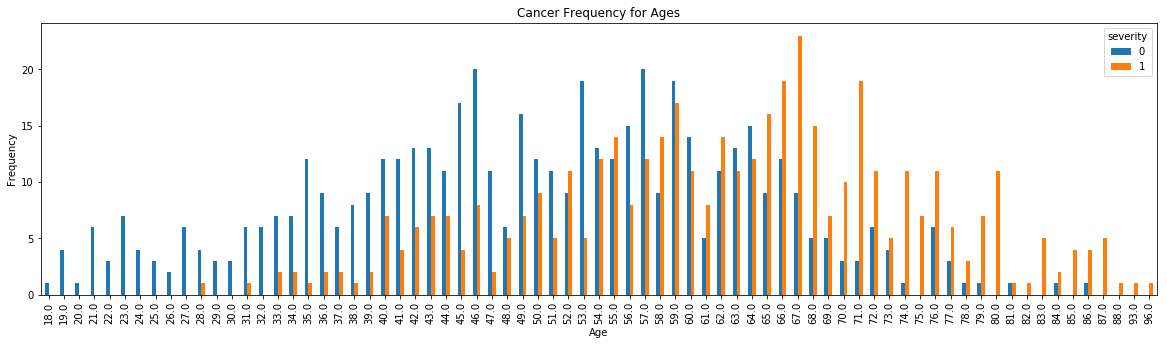

In [144]:
pd.crosstab(masses_data.age,masses_data.severity).plot(kind="bar",figsize=(20,5))
plt.title('Cancer Frequency for Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

If the missing data seems randomly distributed, go ahead and drop rows with missing data. Hint: use dropna().

In [145]:
masses_data.dropna(inplace=True)
masses_data.describe()

,BI-RADS,age,shape,margin,density,severity
count,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000
mean,4.393976,55.781928,2.781928,2.813253,2.915663,0.485542
std,1.888371,14.671782,1.242361,1.567175,0.350936,0.500092
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,46.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


# Histogram

<function matplotlib.pyplot.show(*args, **kw)>

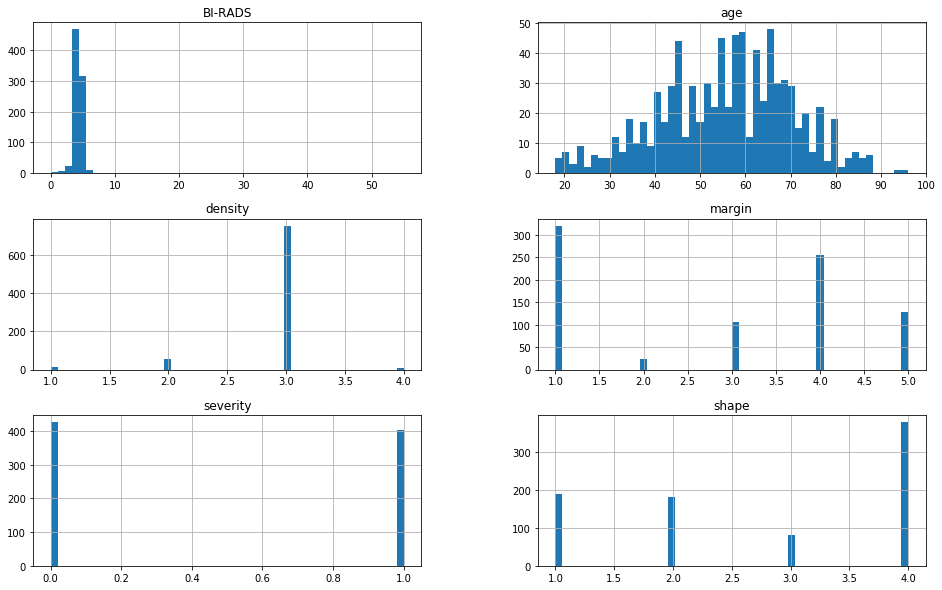

In [146]:
import matplotlib.pyplot as plt
masses_data.hist(bins=50,figsize=(16,10))
plt.show

# Correlation The Attributes

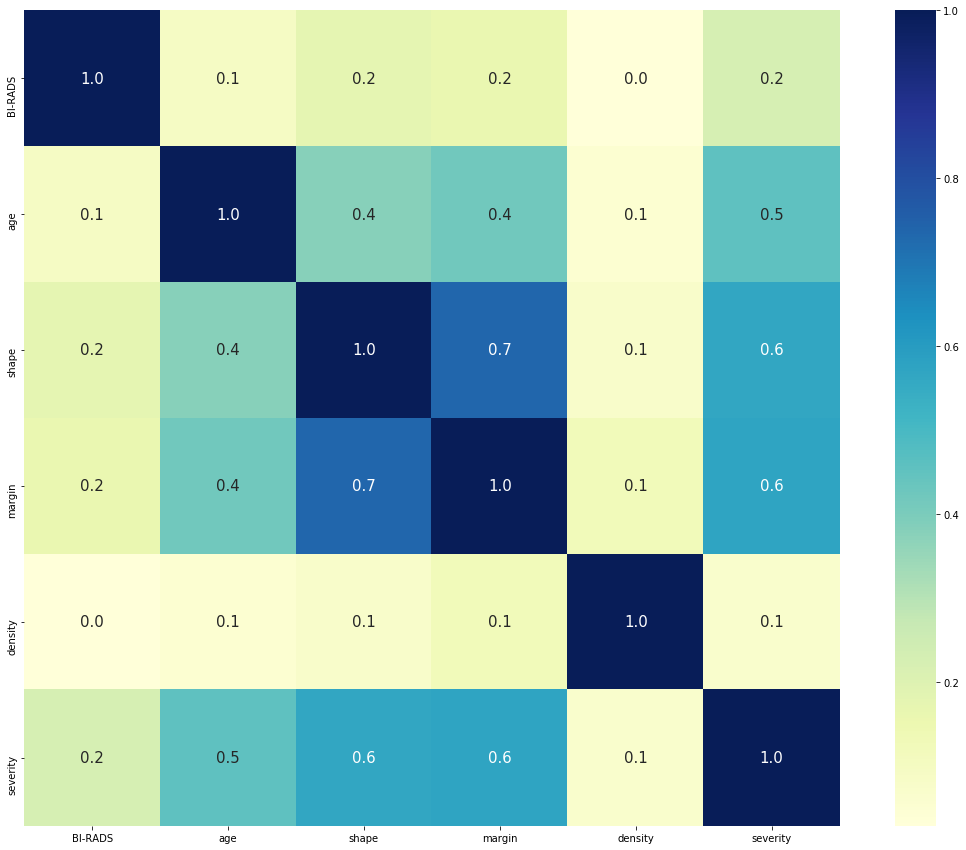

In [147]:
da=masses_data.corr()
da.shape
plt.figure(figsize=(20,15))
sns.heatmap(da, cbar=True, square= True, fmt='.1f', annot=True, annot_kws={'size':15}, cmap='YlGnBu')
plt.show()

Next you'll need to convert the Pandas dataframes into numpy arrays that can be used by scikit_learn. Create an array that extracts only the feature data we want to work with (age, shape, margin, and density) and another array that contains the classes (severity). You'll also need an array of the feature name labels.

In [148]:
all_features = masses_data[['age', 'shape',
                             'margin', 'density']].values


all_classes = masses_data['severity'].values

feature_names = ['age', 'shape', 'margin', 'density']

all_features

array([[67.,  3.,  5.,  3.],
       [58.,  4.,  5.,  3.],
       [28.,  1.,  1.,  3.],
       ...,
       [64.,  4.,  5.,  3.],
       [66.,  4.,  5.,  3.],
       [62.,  3.,  3.,  3.]])

Some of our models require the input data to be normalized, so go ahead and normalize the attribute data. Hint: use preprocessing.StandardScaler().

In [149]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
all_features_scaled = scaler.fit_transform(all_features)
all_features_scaled

array([[ 0.7650629 ,  0.17563638,  1.39618483,  0.24046607],
       [ 0.15127063,  0.98104077,  1.39618483,  0.24046607],
       [-1.89470363, -1.43517241, -1.157718  ,  0.24046607],
       ...,
       [ 0.56046548,  0.98104077,  1.39618483,  0.24046607],
       [ 0.69686376,  0.98104077,  1.39618483,  0.24046607],
       [ 0.42406719,  0.17563638,  0.11923341,  0.24046607]])

# Train and Test

In [150]:
import numpy
from sklearn.model_selection import train_test_split

numpy.random.seed(1234)

X_train, X_test, y_train, y_test= train_test_split(all_features_scaled, all_classes, train_size=0.75, random_state=1)

# DecisionTree

Accuracy is :  74.03846153846155
[73.05389222 74.8502994  73.4939759  74.54545455 69.09090909]


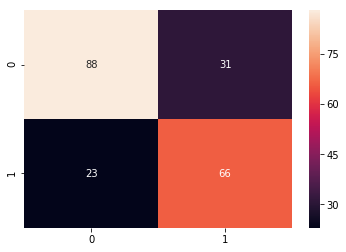

In [151]:
clf_df = DecisionTreeClassifier().fit(X_train,y_train)

ac = accuracy_score(y_test,clf_df.predict(X_test))
print('Accuracy is : ',ac*100)
scores_df = cross_val_score(clf_df, all_features_scaled, all_classes, cv=5)
print(scores_df*100)
cm = confusion_matrix(y_test,clf_df.predict(X_test))
sns.heatmap(cm,annot=True,fmt='d')

# Random Forest

Accuracy is :  76.92307692307693
[71.25748503 79.04191617 73.4939759  78.18181818 72.72727273]


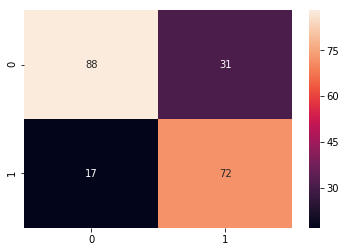

In [152]:
clf_df = RandomForestClassifier(random_state=43).fit(X_train,y_train)

ac = accuracy_score(y_test,clf_df.predict(X_test))
print('Accuracy is : ',ac*100)
scores_df = cross_val_score(clf_df, all_features_scaled, all_classes, cv=5)
print(scores_df*100)
cm = confusion_matrix(y_test,clf_df.predict(X_test))
sns.heatmap(cm,annot=True,fmt='d')

## SVM

Accuracy is :  77.88461538461539
[76.04790419 83.23353293 80.12048193 81.81818182 82.42424242]


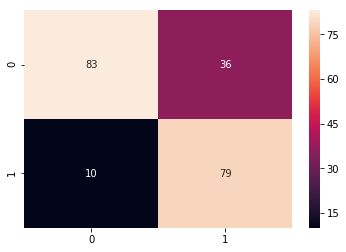

In [153]:
clf_df = svm.SVC(gamma='scale').fit(X_train,y_train)

ac = accuracy_score(y_test,clf_df.predict(X_test))
print('Accuracy is : ',ac*100)
scores_df = cross_val_score(clf_df, all_features_scaled, all_classes, cv=5)
print(scores_df*100)
cm = confusion_matrix(y_test,clf_df.predict(X_test))
sns.heatmap(cm,annot=True,fmt='d')

## KNN

Accuracy is :  0.7740384615384616
[0.74850299 0.78443114 0.80722892 0.80606061 0.75757576]


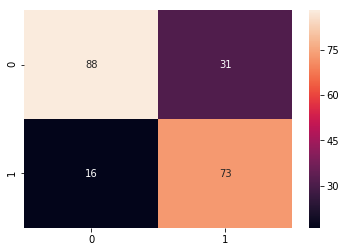

In [154]:
clf_df = KNeighborsClassifier(n_neighbors=5).fit(X_train,y_train)

ac = accuracy_score(y_test,clf_df.predict(X_test))
print('Accuracy is : ',ac)
scores_df = cross_val_score(clf_df, all_features_scaled, all_classes, cv=5)
print(scores_df)
cm = confusion_matrix(y_test,clf_df.predict(X_test))
sns.heatmap(cm,annot=True,fmt='d')

## Naive Bayes

Accuracy is :  77.40384615384616
[74.8502994  83.23353293 78.31325301 77.57575758 77.57575758]


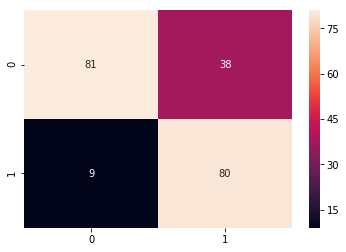

In [155]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()

clf_df = nb.fit(X_train,y_train)
ac = accuracy_score(y_test,clf_df.predict(X_test))
print('Accuracy is : ',ac*100)
scores_df = cross_val_score(clf_df, all_features_scaled, all_classes, cv=5)
print(scores_df*100)
cm = confusion_matrix(y_test,clf_df.predict(X_test))
sns.heatmap(cm,annot=True,fmt='d')

## Logistic Regression

Accuracy is :  77.88461538461539
[76.04790419 83.83233533 77.10843373 80.60606061 83.63636364]


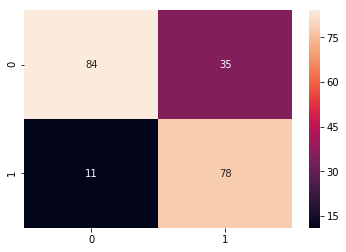

In [156]:
from sklearn.linear_model import LogisticRegression

clf_df = LogisticRegression().fit(X_train,y_train)
ac = accuracy_score(y_test,clf_df.predict(X_test))
print('Accuracy is : ',ac*100)
scores_df = cross_val_score(clf_df, all_features_scaled, all_classes, cv=5)
print(scores_df*100)
cm = confusion_matrix(y_test,clf_df.predict(X_test))
sns.heatmap(cm,annot=True,fmt='d')